In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay
import torch.nn as nn
from torch.optim import Adam
import ta 

[*********************100%***********************]  96 of 96 completed
Tickers:  ['2020.OL', 'ABG.OL', 'ABL.OL', 'ADE.OL', 'AFG.OL', 'AGLX.OL', 'AIRX.OL', 'AKAST.OL', 'AKER.OL', 'AKBM.OL', 'AKRBP.OL', 'ACC.OL', 'AKH.OL', 'AKSO.OL', 'AKVA.OL', 'AMSC.OL', 'ARCH.OL', 'AZT.OL', 'AFK.OL', 'ARR.OL', 'ASTK.OL', 'ASA.OL', 'AURG.OL', 'AUTO.OL', 'AGAS.OL', 'ACR.OL', 'BAKKA.OL', 'BELCO.OL', 'BGBIO.OL', 'BEWI.OL', 'BIEN.OL', 'BNOR.OL', 'BONHR.OL', 'BOR.OL', 'BRG.OL', 'BOUV.OL', 'BWE.OL', 'BWLPG.OL', 'BWO.OL', 'BMA.OL', 'CADLR.OL', 'CARA.OL', 'CRNA.OL', 'CLOUD.OL', 'CONTX.OL', 'CRAYN.OL', 'DNB.OL', 'DNO.OL', 'DOF.OL', 'EWIND.OL', 'EIOF.OL', 'EMGS.OL', 'ELK.OL', 'ELABS.OL', 'ELMRA.OL', 'ELO.OL', 'ENDUR.OL', 'ENSU.OL', 'ENTRA.OL', 'EQNR.OL', 'EQVA.OL', 'EPR.OL', 'FLNG.OL', 'FRO.OL', 'FROY.OL', 'GIG.OL', 'RISH.OL', 'GENT.OL', 'GJF.OL', 'GOGL.OL', 'GOD.OL', 'GCC.OL', 'GSF.OL', 'GYL.OL', 'HAFNI.OL', 'HAVI.OL', 'HEX.OL', 'HPUR.OL', 'HBC.OL', 'HYPRO.OL', 'HAUTO.OL', 'HSPG.OL', 'IDEX.OL', 'IOX.OL', 'ITERA.

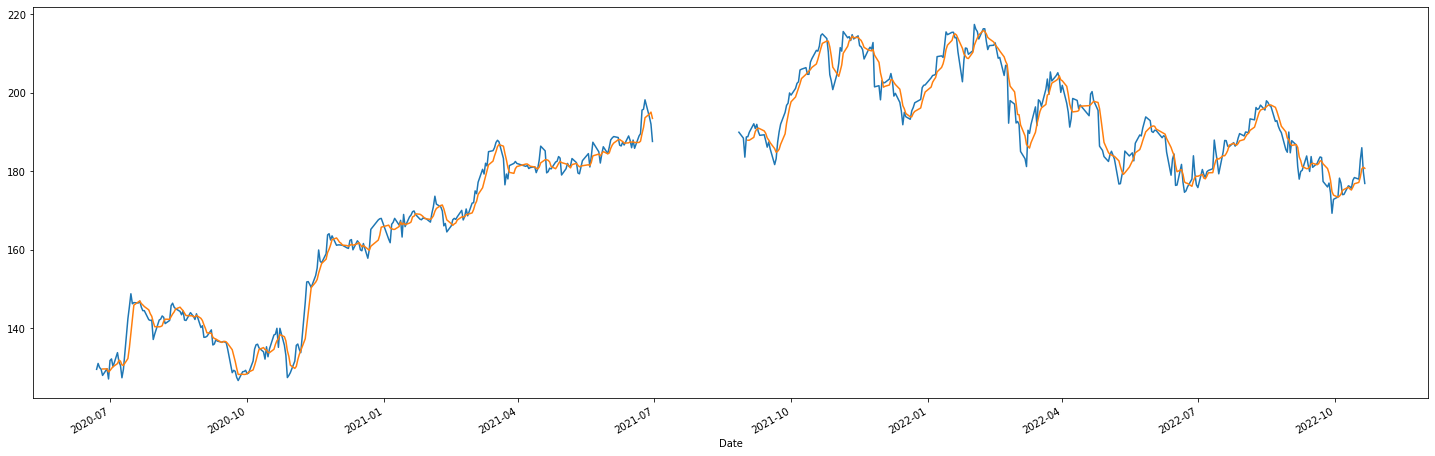

In [36]:

# Set the ticker symbols you're interested in
ticker_list = ['2020.OL', 'ABG.OL', 'ABL.OL', 'ADE.OL', 'AFG.OL', 'AGLX.OL', 'AIRX.OL', 'AKAST.OL', 'AKER.OL', 'AKBM.OL', 'AKRBP.OL', 'ACC.OL', 'AKH.OL', 'AKSO.OL', 'AKVA.OL', 'AMSC.OL', 'ARCH.OL', 'AZT.OL', 'AFK.OL', 'ARR.OL', 'ASTK.OL', 'ASA.OL', 'AURG.OL', 'AUTO.OL', 'AGAS.OL', 'ACR.OL', 'BAKKA.OL', 'BELCO.OL', 'BGBIO.OL', 'BEWI.OL', 'BIEN.OL', 'BNOR.OL', 'BONHR.OL', 'BOR.OL', 'BRG.OL', 'BOUV.OL', 'BWE.OL', 'BWLPG.OL', 'BWO.OL', 'BMA.OL', 'CADLR.OL', 'CARA.OL', 'CRNA.OL', 'CLOUD.OL', 'CONTX.OL', 'CRAYN.OL', 'DNB.OL', 'DNO.OL', 'DOF.OL', 'EWIND.OL', 'EIOF.OL', 'EMGS.OL', 'ELK.OL', 'ELABS.OL', 'ELMRA.OL', 'ELO.OL', 'ENDUR.OL', 'ENSU.OL', 'ENTRA.OL', 'EQNR.OL', 'EQVA.OL', 'EPR.OL', 'FLNG.OL', 'FRO.OL', 'FROY.OL', 'GIG.OL', 'RISH.OL', 'GENT.OL', 'GJF.OL', 'GOGL.OL', 'GOD.OL', 'GCC.OL', 'GSF.OL', 'GYL.OL', 'HAFNI.OL', 'HAVI.OL', 'HEX.OL', 'HPUR.OL', 'HBC.OL', 'HYPRO.OL', 'HAUTO.OL', 'HSPG.OL', 'IDEX.OL', 'IOX.OL', 'ITERA.OL', 'JIN.OL', 'JAREN.OL', 'KAHOT.OL', 'KID.OL', 'KIT.OL', 'KCC.OL', 'KMCP.OL', 'KOMPL.OL', 'KOA.OL', 'KOG.OL', 'LSG.OL']

# Get today's date
end = datetime.today().strftime('%Y-%m-%d')

# Calculate the start date (2 years ago from today)
start = (datetime.today() - timedelta(days=3*365)).strftime('%Y-%m-%d')

# Get the date 3 months ago from today
validation_start = (datetime.today() - timedelta(days=8*30)).strftime('%Y-%m-%d')

def fetch_data(tickers):
    # Fetch data from Yahoo Finance
    data = yf.download(tickers, start=start, end=end)
    
    # If data is empty, return None
    if data.empty:
        return None
    
    # Sort the data in ascending order of date (if not already)
    data.sort_index(inplace=True)

    data = data.swaplevel(axis=1)
    for ticker in ticker_list:
        close_data = data.loc[:, (ticker, 'Close')]  # Using .loc to access the 'Close' column

        # Calculate the 5-day moving average for each stock
        moving_average = close_data.rolling(window=5).mean()

        # Assign the moving average values back to the DataFrame
        data.loc[:, (ticker, '5-day Moving Average')] = moving_average
    desired_order = ['Adj Close', 'Close', 'High', 'Low', 'Open', '5-day Moving Average', 'Volume',]
    data = data.swaplevel(axis=1)
    data = data[desired_order]
    data = data.swaplevel(axis=1)
    
    # Split data into training and validation datasets
    training_data = data[data.index < validation_start]#.swaplevel(axis = 1)
    validation_data = data[data.index >= validation_start]#.swaplevel(axis = 1)

    return (tickers, training_data, validation_data)

# Create a ThreadPoolExecutor
results = fetch_data(ticker_list)

# Remove any None results (i.e., failed downloads)
results = [result for result in results if result is not None]

# Split results into separate lists
tickers, training_data_list, validation_data_list = results

print('Tickers: ', tickers)
print('Training data: ', training_data_list['DNB.OL'].columns)
#print('Val:, ', validation_data_list.head(2))

training_data_list['DNB.OL']['Close'].plot(figsize = (25, 8))
training_data_list['DNB.OL']['5-day Moving Average'].plot()
plt.show()

In [37]:
sequence_length = 15
training_samples = []
errors = 0
for start_idx in range(0, len(training_data_list) - sequence_length):
    seq = training_data_list.iloc[start_idx : start_idx + sequence_length]#.values
    labels = training_data_list.iloc[start_idx + sequence_length]
    for ticker in ticker_list:
        
        day = seq.index[-1].weekday()

        sample = seq[ticker].values
        label = labels[ticker].values

        closing_prices = sample[:, 1]
        percentage_change = [(closing_prices[i] - closing_prices[i-1]) / closing_prices[i-1] * 100 for i in range(1, len(closing_prices))]
        price_std = np.std(percentage_change)

        # compute mean of price sequences
        mean_p = np.mean(sample[:, 1])
        std_p = np.std(sample[:, 1])

        mean_v = np.mean(sample[:, -1])
        std_v = np.std(sample[:, -1])

        if (std_p == 0).any() or (std_v == 0).any():
            continue

        sample[:, :-1] = (sample[:, :-1] - mean_p) / std_p
        label[:-1] = (label[:-1] - mean_p) / std_p

        sample[:, -1] = (sample[:, -1] - mean_v) / std_v
        label[-1] = (label[-1] - mean_v) / std_v

        # If only close 
        label = label[1]

        if not np.isnan(sample).any():
            if not np.isnan(label).any():
                sample = sample.flatten()
                sample = np.append(sample, day)
                sample = np.append(sample, price_std)
                training_samples.append((sample, label))
        else:
            errors += 1

print('Encountered errors: {}'.format(errors))
print('Number of training samples: {}'.format(len(training_samples)))

val_samples = []
val_errors = 0
for start_idx in range(0, len(validation_data_list) - sequence_length):
    seq = validation_data_list.iloc[start_idx : start_idx + sequence_length]#.values
    labels = validation_data_list.iloc[start_idx + sequence_length]
    for ticker in ticker_list:

        day = seq.index[-1].weekday()

        sample = seq[ticker].values
        label = labels[ticker].values

        closing_prices = sample[:, 1]
        percentage_change = [(closing_prices[i] - closing_prices[i-1]) / closing_prices[i-1] * 100 for i in range(1, len(closing_prices))]
        price_std = np.std(percentage_change)

        # compute mean of price sequences
        mean_p = np.mean(sample[:, 1])
        std_p = np.std(sample[:, 1])

        mean_v = np.mean(sample[:, -1])
        std_v = np.std(sample[:, -1])

        if (std_p == 0).any() or (std_v == 0).any():
            continue

        sample[:, :-1] = (sample[:, :-1] - mean_p) / std_p
        label[:-1] = (label[:-1] - mean_p) / std_p

        sample[:, -1] = (sample[:, -1] - mean_v) / std_v
        label[-1] = (label[-1] - mean_v) / std_v

        # If only close 
        label = label[1]

        if not np.isnan(sample).any():
            if not np.isnan(label).any():
                sample = sample.flatten()
                sample = np.append(sample, day)
                sample = np.append(sample, price_std)
                val_samples.append((sample, label))
        else:
            val_errors += 1

print('Encountered errors: {}'.format(val_errors))
print('Number of val samples: {}'.format(len(val_samples)))


Encountered errors: 4021
Number of training samples: 51235
Encountered errors: 425
Number of val samples: 13588


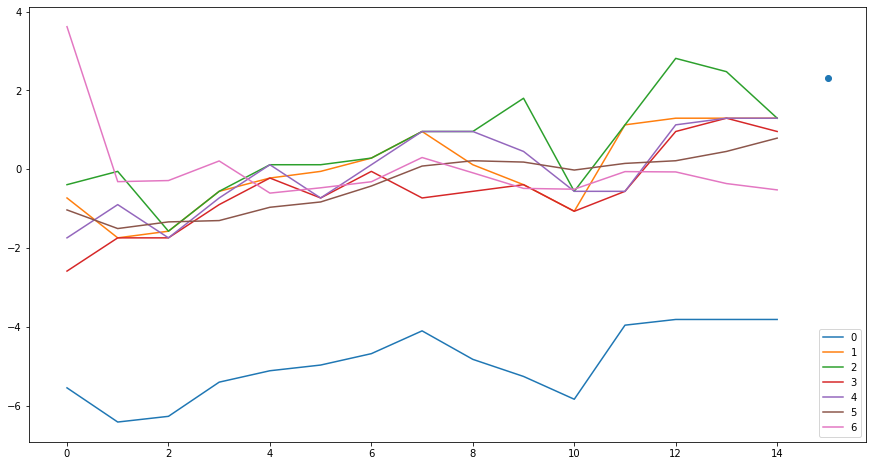

In [38]:
s = 2
plt.figure(figsize=(15, 8))
for i in range(0,7):
    plt.plot(training_samples[s][0][i:-2:7], label=f'{i}')
    if i == 1:
        plt.scatter([sequence_length], y = training_samples[s][1])
plt.legend()
plt.show()

### RANDOM FOREST ###

In [45]:
def simulate_trading(model, fee = 0.005, buy_threshold = 0.01):
    """
    Simulates trading for a given number of days.
    """

    sequence_length = 15
    money = 1

    for start_idx in range(0, len(validation_data_list) - sequence_length):
        seq = validation_data_list.iloc[start_idx : start_idx + sequence_length]#.values
        labels = validation_data_list.iloc[start_idx + sequence_length]
        for ticker in ticker_list:

            # Get purchace price
            buy_value = seq[ticker].values.flatten()[-5]

            # Get input data
            sample = seq[ticker].values
            day = seq.index[-1].weekday()
            closing_prices = sample[:, 1]
            percentage_change = [(closing_prices[i] - closing_prices[i-1]) / closing_prices[i-1] * 100 for i in range(1, len(closing_prices))]
            price_std = np.std(percentage_change)

            # NORMALIZE
            mean_p = np.mean(sample[:, 1])
            std_p = np.std(sample[:, 1])

            mean_v = np.mean(sample[:, -1])
            std_v = np.std(sample[:, -1])

            if (std_p == 0).any() or (std_v == 0).any():
                continue

            sample[:, :-1] = (sample[:, :-1] - mean_p) / std_p
            sample[:, -1] = (sample[:, -1] - mean_v) / std_v
            sample = sample.flatten()

            sample = np.append(sample, day)
            sample = np.append(sample, price_std)

            # Get label
            label = labels[ticker].values[-5]

            # If only close 
            profit_ratio = (label / buy_value) - fee # Assuming fee

            if not np.isnan(sample).any():
                if not np.isnan(label).any():
                    pred = (model.predict(sample.reshape(1, -1)) * std_p) + mean_p
                    if pred > buy_value*buy_threshold:
                        money = money * profit_ratio
                        print(f'Ticker: {ticker} | Price: {buy_value:.2f} | Prediction {pred[0]:.2f}| Sell Price: {label:.2f} | Profit: {profit_ratio:.2f} | Money: {money:.2f}')
    print(money)


a = list(training_data_list['DNB.OL'].columns) + ['DAY', 'Price STD']
b = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

def check_earnings_full(X, y, preds, feature = 'Close'):

    feature_x = a.index(feature) - len(a)
    feature_y = b.index(feature) - len(b)

    binary_label = X[:, feature_x] < y[:, feature_y]
    binary_pred = X[:, feature_x] < preds[:, feature_y]

    vals, counts = np.unique(binary_label, return_counts=True)
    plt.bar(vals, counts)
    plt.title(f'{counts/len(y)}')
    plt.show()

    pred_trunover = preds[:, feature_y] - X[:, feature_x]
    #p, r, _ = precision_recall_curve(binary_label, pred_trunover)
    pr_display = PrecisionRecallDisplay.from_predictions(binary_label, pred_trunover)
    #pr_display.plot()
    plt.show()

    total_return = accuracy_score(binary_label, binary_pred)
    return total_return

def check_earnings(X, y, preds, feature = 'Close'):

    feature_x = a.index(feature) - len(a)

    binary_label = X[:, feature_x] < y[:]
    binary_pred = X[:, feature_x] < preds[:]

    vals, counts = np.unique(binary_label, return_counts=True)
    plt.bar(vals, counts)
    plt.title(f'{counts/len(y)}')
    plt.show()

    pred_trunover = preds[:] - X[:, feature_x]
    pr_display = PrecisionRecallDisplay.from_predictions(binary_label, pred_trunover)
    #pr_display.plot()
    plt.show()

    total_return = accuracy_score(binary_label, binary_pred)
    return total_return

In [57]:
model = RandomForestRegressor(n_estimators = 500, n_jobs=-1, verbose = False, max_samples=1., oob_score=True, min_samples_split=5, max_features=0.1)

X_train, y_train = zip(*training_samples)
X_val, y_val = zip(*val_samples)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [58]:
model = model.fit(X_train, y_train)

0.16587228561755596


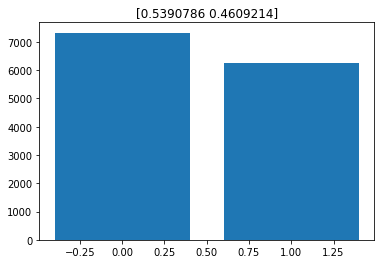

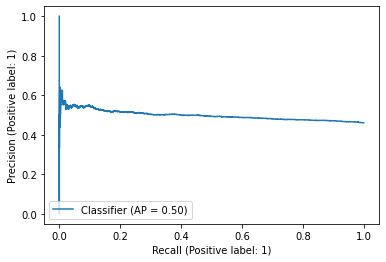

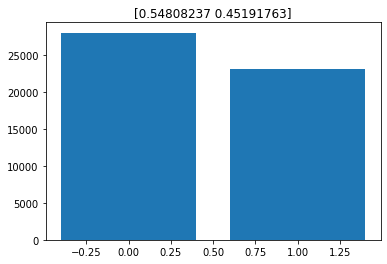

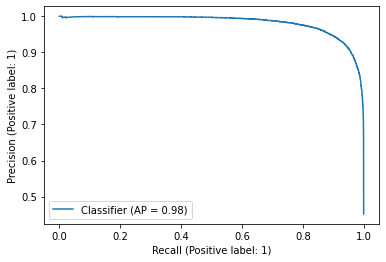

Binary validation accuracy:  0.527671474830733
Binary training accuracy:  0.9249731628769396


In [59]:
val_score = 0
train_score = 0
print(model.score(X_val, y_val))
val_score += check_earnings(X_val, y_val, model.predict(X_val))
train_score += check_earnings(X_train, y_train, model.predict(X_train))
print('Binary validation accuracy: ', val_score)
print('Binary training accuracy: ', train_score)
plt.show()

In [61]:
simulate_trading(model, fee = 0.01, buy_threshold=1.00)

Ticker: ADE.OL | Price: 86.50 | Prediction 86.68| Sell Price: 87.45 | Profit: 1.00 | Money: 1.00
Ticker: CRNA.OL | Price: 1.17 | Prediction 1.17| Sell Price: 1.18 | Profit: 1.00 | Money: 1.00
Ticker: GENT.OL | Price: 42.00 | Prediction 42.02| Sell Price: 42.90 | Profit: 1.01 | Money: 1.01
Ticker: GOD.OL | Price: 8.00 | Prediction 8.00| Sell Price: 7.94 | Profit: 0.98 | Money: 0.99
Ticker: JAREN.OL | Price: 228.00 | Prediction 228.35| Sell Price: 230.00 | Profit: 1.00 | Money: 0.99
Ticker: AKVA.OL | Price: 48.80 | Prediction 49.79| Sell Price: 49.70 | Profit: 1.01 | Money: 1.00
Ticker: AURG.OL | Price: 212.00 | Prediction 212.17| Sell Price: 212.00 | Profit: 0.99 | Money: 0.99
Ticker: BOR.OL | Price: 1.50 | Prediction 1.51| Sell Price: 1.50 | Profit: 0.99 | Money: 0.98
Ticker: CONTX.OL | Price: 8.96 | Prediction 8.97| Sell Price: 9.07 | Profit: 1.00 | Money: 0.98
Ticker: ELABS.OL | Price: 16.44 | Prediction 16.56| Sell Price: 16.50 | Profit: 0.99 | Money: 0.97
Ticker: RISH.OL | Price: 1

### DEEP LEARNING ###

In [ ]:
device = "cpu" if torch.cuda.is_available() else "cpu"

class StockDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.sequence_length = sequence_length

    def __len__(self):
        # Return the number of sequences that can be created
        return len(self.data)

    def __getitem__(self, index):
        data, label = self.data[index]
        return torch.tensor(data, dtype=torch.float32, device=device).flatten(), torch.tensor(label, dtype=torch.float32, device=device)


In [ ]:
training_dataset = StockDataset(training_samples)
validation_dataset = StockDataset(val_samples)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(training_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=512, shuffle=False)


In [ ]:
k = 2*8
d = 0.3
model = nn.Sequential(
    nn.Linear(62, 48*k),
    nn.Dropout(d),
    nn.LeakyReLU(),
    nn.BatchNorm1d(48*k),
    nn.Linear(48*k, 48*k),
    nn.Dropout(d),
    nn.LeakyReLU(),
    nn.BatchNorm1d(48*k),
    nn.Linear(48*k, 32*k),
    nn.Dropout(d),
    nn.LeakyReLU(),
    nn.BatchNorm1d(32*k),
    nn.Linear(32*k, 8*k),
    nn.Dropout(d),
    nn.LeakyReLU(),
    nn.BatchNorm1d(8*k),
    nn.Linear(8*k, 1),
    nn.Flatten(0)
).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    for x, y, in train_loader:
        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        loss.backward()

        optimizer.step()

        #print(loss.item())

        # print results after every 1 epoch
    if epoch % 1 == 0:
        with torch.no_grad():
            e = []
            for x_test, y_test in val_loader:
                preds = model(x_test)
                e.append(check_earnings(x_test.cpu(), y_test.cpu(), preds.cpu()))
            print(f"Epoch: {epoch} - Earnings: {np.mean(e)}")

            e = []
            for x_test, y_test in train_loader:
                preds = model(x_test)
                e.append(check_earnings(x_test.cpu(), y_test.cpu(), preds.cpu()))
            print(f"Epoch: {epoch} - Earnings: {np.mean(e)}")

